# HTS Fingerprints (PubChem)
### Reproducing the HTS Fingerprints for compounds in the PubChem BioAssay database based on (Helal et al., 2016)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
plt.rcParams["font.family"] = "Palatino"

In [3]:
class DataProcess:
    def __init__(self, directory, cut_off_assays, cut_off_compounds, range='all'):
        '''

        '''
        self.directory = directory
        self.cut_off_assays = cut_off_assays
        self.cut_off_compounds = cut_off_compounds

        # read the AIDs from the file
        self.read_AIDs()
    
        if range == 'all':
            self.range = len(self.AIDs)
        else:
            self.range = range

    
    def read_AIDs(self):
        '''
        Read the AIDs assay identifiers from the file with AID numbers of the downloaded assays from PubChem
        Save a list of AIDs as an attribute of the class.
        '''
        # path to the file with AID numbers of the downloaded assays from PubChem
        AID_path = self.directory + '/info/pcassay_result_AID.txt'
        with open(AID_path, 'r') as file:
            lines = file.read().splitlines()

        # convert to integers
        self.AIDs = list(map(int, lines))


    # import the bioassay data downloaded from PubChem
    def load_bioassay_data(self, AID):
        ''''
        Load the bioassay data from the csv file for a given AID.
        Return a DataFrame with the data.
        '''
        # import csv file from path
        path = self.directory + f'/AID_{AID}.csv'
        df = pd.read_csv(path, sep=',', header=0, dtype={'PUBCHEM_CID': 'Int64', 'PUBCHEM_EXT_DATASOURCE_SMILES': str, 'PUBCHEM_ACTIVITY_OUTCOME': str,'Compound QC':str}, low_memory=False)
        # drop the first column
        df = df.drop(df.columns[0], axis=1)
        # drop rows with NaN values in the 'PUBCHEM_SID' column
        df = df.dropna(subset=['PUBCHEM_CID'])
        # reset the index
        df = df.reset_index(drop=True)
        
        return df
    
    def find_valid_compounds(self):
        '''
        Filter the compounds to only include those that appear in at least 'cut_off_assays' number of assays.
        Returns a list of valid CIDs.
        '''

        # create a Counter object to hold the counts of each CID
        counter = Counter()
        # dictionary to hold the number of compounds per assay
        self.compounds_per_assay = {}

        # go through each bioassay and count the number of times each CID appears
        for AID in self.AIDs[:self.range]:
            df = self.load_bioassay_data(AID)

            # check if the 'CID' column exists in the DataFrame
            assert 'PUBCHEM_CID' in df.columns, f"DataFrame for AID {AID} does not have a 'CID' column"
            # update the counter with the CIDs in the 'CID' column
            counter.update(df['PUBCHEM_CID'])

            # count the number of unique compounds in the filtered DataFrame
            self.compounds_per_assay[AID] = df['PUBCHEM_CID'].nunique()
        
        # save the number of unique compounds
        self.cids = len(counter)
        
        # filter the counter to only include CIDs that appear in at least 'cut_off_assays' number of assays
        filtered_counter = {cid: count for cid, count in counter.items() if count >= self.cut_off_assays}

        # list of CIDs that appear in at least 'cut_off_assays' number of assays
        self.valid_cids = list(filtered_counter.keys())



    def filter_assays(self):
        '''
        Filter the invalid compounds from each assay.
        Filter the assays to only include those that contain at least 'cut_off_compounds' number of compounds and have a primary activity column.
        Convert the primary activity column to a Z-score.
        Save the number of valid compounds per assay as an attribute of the class.
        Save the valid assays AIDs as an attribute of the class.
        Save the primary activity column names as an attribute of the class.
        Save the filtered assays to new CSV files.
        '''
        self.valid_compounds_per_assay = {}
        self.valid_AIDs = []
        self.primary_activity_columns = {}

        # go through each bioassay file and discard rows with CIDs that are not in the 'valid_cids'
        for AID in self.AIDs[:self.range]:

            df = self.load_bioassay_data(AID)        
            # filter the DataFrame to only include rows with a valid CID
            df = df[df['PUBCHEM_CID'].isin(self.valid_cids)]

            # count the number of unique compounds in the filtered DataFrame
            unique_compounds = df['PUBCHEM_CID'].nunique()
            self.valid_compounds_per_assay[AID] = unique_compounds

            # only write the filtered assay to a new CSV file if it contains enough unique compounds and has a primary activity column
            if unique_compounds >= self.cut_off_compounds:
                # check if any of the primary activity columns exists in the DataFrame, primary activity can be different for each assay type
                primary_found, primary_activity_column = self.find_primary_activity_column(df)
                # save the primary activity column name  
                self.primary_activity_columns[AID] = primary_activity_column
                if primary_found:
                
                    self.valid_AIDs.append(AID)  

                    # check if the 'PUBCHEM_EXT_DATASOURCE_SMILES' column exists in the DataFrame
                    assert 'PUBCHEM_EXT_DATASOURCE_SMILES' in df.columns, f"AID {AID} does not have a SMILES column"    
                    
                    # calculate the Z-score for each compound in the assay based on the primary activity column
                    df = self.get_Z_score(df, primary_activity_column)  

                    # write the filtered DataFrame to a new CSV file with only the columns needed further: Z-scores and SMILES
                    df[['PUBCHEM_CID', 'PUBCHEM_EXT_DATASOURCE_SMILES', 'Z_score']].to_csv(self.directory + f'/filtered/AID_{AID}.csv', index=False)
            
                

    def print_columns(self):
        '''
        Print the column names of the assays.
        '''
        for AID in self.AIDs[:self.range]:
            df = self.load_bioassay_data(AID)
            # print the column names of the assay
            print(df.columns)

        
        

    def find_primary_activity_column(self, df):
        '''
        Find the primary activity column in the DataFrame.
        - First check if the column name matches the regular expression pattern for "Inhibition at X" or "Activation at X".
        - If no match is found, check for additional primary activity columns.
        - If no additional primary activity column is found, return the generic primary activity column.
        Return a tuple with a boolean value indicating if a primary activity column was found and the name of the primary activity column.
        '''

        if 'PUBCHEM_ACTIVITY_SCORE' not in df.columns:
            return False, None

        # compile the regular expression pattern for both "Inhibition at X" and "Activation at X"
        pattern = re.compile(r'(Inhibition|Activation) at \d+')

        primary_2 = False
        # check each column for a match to the pattern
        for column in df.columns:
            # if the column name matches the pattern
            if pattern.match(column):
                return True, column
            # if no match was found, check for additional primary activity columns
            elif column in ['Max_Response', 'Max_response', 'Percent Activity']:
                primary_2 = True
                primary_column = column

        # if additional primary activity columns were found, return the first one    
        if primary_2:
            return True, primary_column
        # if no primary activity column was found, return the generic primary activity column
        else:
            return True, 'PUBCHEM_ACTIVITY_SCORE'
        

    def get_Z_score(self, df, primary_activity_column):
        '''
        Given the primary activity column, calculate the Z-score for each compound in the assay.
        '''
        # calculate the mean and standard deviation of the primary activity column
        # convert the column to float
        df[primary_activity_column] = df[primary_activity_column].astype(float)
        mean = df[primary_activity_column].mean()
        std = df[primary_activity_column].std()

        # calculate the Z-score for each compound
        df['Z_score'] = (df[primary_activity_column] - mean) / std
        df.head()

        return df
    
    def statistics(self):
        print('-------------------------------------')
        print('# compounds before filtering:', self.cids)
        print('# compounds after filtering:', len(self.valid_cids))
        print('# assays before filtering:', len(self.AIDs[:self.range]))
        print('# assays after filtering:', len(self.valid_AIDs))
        print('-------------------------------------')

        # plot the number of compounds per assay histogram
        plt.hist(self.compounds_per_assay.values(), bins=100)
        plt.xlabel('Number of compounds per assay')
        plt.ylabel('Number of assays')
        plt.title('Number of compounds per assay(after filtering)')
        # show ylabel integers
        plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
        plt.savefig(self.directory+'/info/compounds_per_assay.png', dpi=500)
        plt.show()

        # plot the primary activity column histogram
        primary_activity_columns_clean = self.primary_activity_histogram()
        plt.hist(primary_activity_columns_clean.values(), bins=100)
        plt.xlabel('Primary activity column')
        # make the xlabels angled
        plt.xticks(rotation=45)
        plt.ylabel('Number of assays')
        plt.title('Primary activity types')
        plt.savefig(self.directory+'/info/primary_activity.png', dpi=500)
        plt.show()
    
    def primary_activity_histogram(self):

        # Regular expressions for 'Inhibition X' and 'Activation X'
        pattern_inhibition = re.compile(r'Inhibition at \d+')
        pattern_activation = re.compile(r'Activation at \d+')

        # Create a new dictionary
        primary_activity_columns_clean = {}

        # Iterate over the items in dict1
        for key, value in self.primary_activity_columns.items():
            # If the value matches the 'Inhibition X' pattern, replace it with 'Inhibition'
            if pattern_inhibition.match(value):
                primary_activity_columns_clean[key] = 'Inhibition'
            # If the value matches the 'Activation X' pattern, replace it with 'Activation'
            elif pattern_activation.match(value):
                primary_activity_columns_clean[key] = 'Activation'
            # Otherwise, copy the value as is
            else:
                primary_activity_columns_clean[key] = value

        return primary_activity_columns_clean


    def compare_to_Helal(self):
        '''
        Compare the valid AIDs to the valid AIDs used by Helal et al.
        '''
        # Load the Excel file with the AIDs used by Helal et al.
        df = pd.read_excel(directory+'/info/Helal_AIDs.xlsx')

        # Get the 'AID' column data into a list
        self.AIDs_Helal = df['AID'].tolist()

        # Convert the lists to sets
        set1 = set(self.AIDs_Helal)
        set2 = set(self.valid_AIDs)

        # Find the intersection (overlap)
        overlap = set1 & set2
        print('-------------------------------------')
        print('# Helal valid AIDs:', len(set1), '| # my valid AIDs:', len(set2))
        print("# overlap:", len(overlap))
        print('-------------------------------------')


    def create_activity_matrix(self):
        '''
        Create an activity matrix with the valid compounds and assays.
        '''
        # First, we'll need to concatenate all the csv files into a single DataFrame
        # For this, place all assay csv files into a list
        assay_files = [f'AID_{AID}.csv' for AID in self.valid_AIDs]

        # Initialize an empty DataFrame to store the final result
        final_df = pd.DataFrame()

        # Process each csv file
        for i, file in enumerate(assay_files):
           
            # Read the csv file
            df = pd.read_csv(self.directory + '/filtered/' + file)

            # Rename the 'Z_score' column to the corresponding AID
            df = df.rename(columns={'Z_score': self.valid_AIDs[i]})
            # Drop the 'PUBCHEM_EXT_DATASOURCE_SMILES' column
            df = df.drop(columns=['PUBCHEM_EXT_DATASOURCE_SMILES'])
            # rename the 'PUBCHEM_CID' column to 'CID'
            df = df.rename(columns={'PUBCHEM_CID': 'CID'})

            # If final_df is empty, copy df to final_df
            if final_df.empty:
                final_df = df
            else:
                # Merge df with final_df
                final_df = pd.merge(final_df, df, on='CID', how='outer')

        # Save the final DataFrame as a csv file
        final_df.to_csv('activity_matrix.csv', index=False)

    def check_correct(self):
        '''
        Check if the activity matrix was created correctly.
        '''

        # Load the matrix
        matrix_df = pd.read_csv('activity_matrix.csv')

        print('_____________________________________')
        # Sanity check for NaN values
        print("Total NaN values in the matrix:", matrix_df.isna().sum().sum())
        # proportion of NaN values
        print("Proportion of NaN values in the matrix:", matrix_df.isna().sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1]))
        print('--------------------------------')
        # Sanity check for data types
        print("Data types in the matrix:\n", matrix_df.dtypes)
        print('--------------------------------')
        # Sanity check for dimensions
        print("Dimensions of the matrix:", matrix_df.shape)
        print('Dimensions expected: ', f'({len(self.valid_cids)}, {len(self.valid_AIDs)+1})')
        print('--------------------------------')
        # Statistical analysis
        print("Statistics for each AID column:\n", matrix_df.describe())
        print('--------------------------------')
        # Check for duplicate CIDs
        duplicate_cids = matrix_df['CID'].duplicated()

        # Count the number of duplicates
        num_duplicates = duplicate_cids.sum()

        # Print the number of duplicate CIDs
        print("Number of duplicate CIDs:", num_duplicates)

        # If you want to see the duplicated rows:
        print("Duplicated rows:")
        print(matrix_df[matrix_df['CID'].duplicated(keep=False)])
        print('_____________________________________')
    
    def avg_duplicate_CIDs(self):
        '''
        Average the Z-scores for duplicate CIDs.
        '''
        # Load the matrix
        matrix_df = pd.read_csv('activity_matrix.csv')

        # Group by 'CID' and calculate the mean for each group
        averaged_df = matrix_df.groupby('CID', as_index=False).mean()

        # Save the new DataFrame with averaged values to a csv file
        averaged_df.to_csv('activity_matrix.csv', index=False)






In [4]:
range = 52
directory = 'Data/PubChem data'
cut_off_assays = 25
cut_off_compounds = 280000

data_process = DataProcess(directory, cut_off_assays, cut_off_compounds, range=range)

In [5]:
data_process.find_valid_compounds()
data_process.filter_assays()



In [6]:
data_process.create_activity_matrix()

: 

: 

In [191]:
data_process.avg_duplicate_CIDs()

In [192]:
data_process.check_correct()

_____________________________________
Total NaN values in the matrix: 30651
Proportion of NaN values in the matrix: 0.012442367130814739
--------------------------------
Data types in the matrix:
 CID          int64
1347041    float64
652048     float64
652051     float64
1259415    float64
624414     float64
dtype: object
--------------------------------
Dimensions of the matrix: (410573, 6)
Dimensions expected:  (410573, 6)
--------------------------------
Statistics for each AID column:
                 CID        1347041         652048         652051  \
count  4.105730e+05  408208.000000  407539.000000  407539.000000   
mean   1.311313e+07      -0.003558       0.001031       0.001031   
std    2.355670e+07       0.990193       0.988381       0.988381   
min    6.000000e+00     -37.970162     -11.125492     -11.125492   
25%    2.085673e+06      -0.499695      -0.433988      -0.433988   
50%    4.127473e+06       0.042824       0.114855       0.114855   
75%    1.602677e+07       0.

-------------------------------------
# assays before filtering: 25
# assays after filtering: 24
# compounds before filtering: 589999
# compounds after filtering: 372670
-------------------------------------


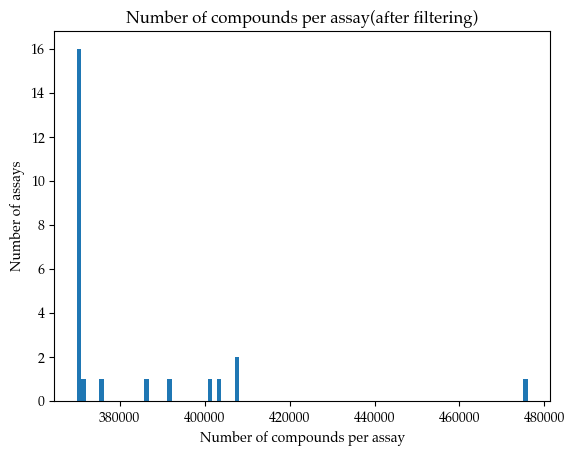

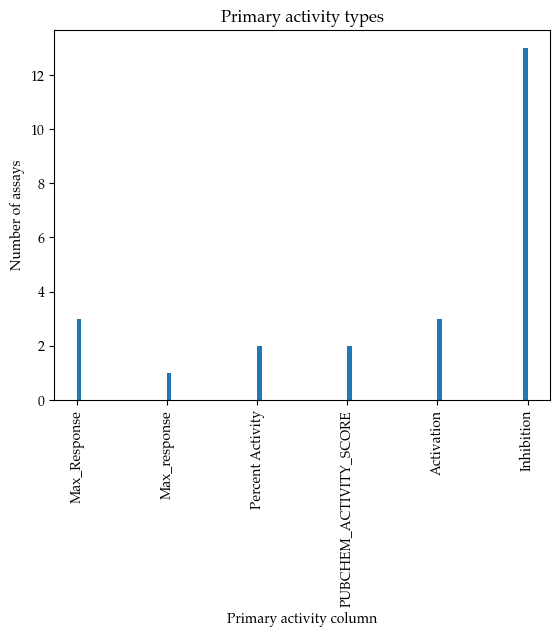

In [140]:
data_process.statistics()


In [ ]:
data_process.compare_to_Helal()

In [100]:
data_process.print_columns()

Index(['PUBCHEM_SID', 'PUBCHEM_CID', 'PUBCHEM_EXT_DATASOURCE_SMILES',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT', 'Max_Response',
       'Activity at 2.29 uM', 'Activity at 11.40 uM', 'Activity at 57.10 uM',
       'Activity at 114.0 uM', 'Activity at 229.0 uM', 'Compound QC'],
      dtype='object')
Index(['PUBCHEM_SID', 'PUBCHEM_CID', 'PUBCHEM_EXT_DATASOURCE_SMILES',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT', 'Phenotype',
       'Potency', 'Efficacy', 'Analysis Comment', 'Activity_Score',
       'Curve_Description', 'Fit_LogAC50', 'Fit_HillSlope', 'Fit_R2',
       'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Fit_CurveClass',
       'Excluded_Points', 'Max_Response', 'Activity at 0.230 uM',
       'Activity at 1.030 uM', 'Activity at 1.150 uM', 'Activity at 2.300 uM',
       'Activity at 4.600 uM', 'Activity at 5.158 uM', 'Activity a